## Daniel Howard, dah2183, QMSS 5074, Spring 2020 HW1
## Assignment #1: Write up a report on U.N. World Happiness Data.
## Github Link : https://github.com/dhoward0497/QMSS5074_HW1

#### Please note, all the code and plots are presented below. The write up of the report and any findings found are typed up after the code and at the end of this documet.

### Package Imports

In [1]:
from matplotlib import pyplot
from numpy import loadtxt
from scipy import stats
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

### Data Imports

In [2]:
hap_data = pd.read_csv("worldhappiness2019.csv")
hap_data["region"] = np.nan

hap_data_test = pd.read_csv("worldhappiness2019predictions.csv")
hap_data_test["region"] = np.nan

reg_data = pd.read_excel("region_data.xlsx")
reg_data["name_coded"] = np.nan

In [3]:
# additional variables

# retrieved from https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions
co_emissions = pd.read_csv("co-emissions-per-capita.csv")
hap_data["CO2-per-capita"] = np.nan
hap_data_test["CO2-per-capita"] = np.nan

# retrieved from https://ourworldindata.org/fertility-rate
fertility_rate = pd.read_csv("fertility-rate.csv")
hap_data["fertility-rate"] = np.nan
hap_data_test["fertility-rate"] = np.nan

# retrieved from https://ourworldindata.org/child-mortality
mortality_rate = pd.read_csv("mortality-rate.csv")
hap_data["infant-mortality-rate"] = np.nan
hap_data_test["infant-mortality-rate"] = np.nan

# additional variables from https://www.kaggle.com/fernandol/countries-of-the-world
additional_data = pd.read_csv("countries-of-the-world.csv")
hap_data["pop-density"] = np.nan
hap_data["net-migration"] = np.nan
hap_data["literacy-rate"] = np.nan
hap_data["death-rate"] = np.nan
hap_data_test["pop-density"] = np.nan
hap_data_test["net-migration"] = np.nan
hap_data_test["literacy-rate"] = np.nan
hap_data_test["death-rate"] = np.nan

In [4]:
# add new variable denoting world region based on country name

d = dict()

for reg in reg_data["region"]:
    
    if reg in d:
        d[reg] = d[reg]+1
    else:
        d[reg] = 1
        
c = 1
for reg in d:
    d[reg] = c
    c+=1
    
pos = 0
for name in reg_data["region"]:
    x = reg_data["region"][pos]
    reg_data["name_coded"][pos] = d.get(x)
    pos+=1
    

for country1 in hap_data["Country or region"]:
    for country2 in reg_data["name"]:
        if country1 == country2:
            ind1 = hap_data["Country or region"][hap_data["Country or region"] == country1].index
            ind2 = reg_data["name"][reg_data["name"] == country2].index
            hap_data["region"][ind1] = reg_data["name_coded"][ind2]

for country1 in hap_data_test["Country or region"]:
    for country2 in reg_data["name"]:
        if country1 == country2:
            ind1 = hap_data_test["Country or region"][hap_data_test["Country or region"] == country1].index
            ind2 = reg_data["name"][reg_data["name"] == country2].index
            hap_data_test["region"][ind1] = reg_data["name_coded"][ind2]
            
hap_data = hap_data.dropna(axis=0, subset=['region'])
hap_data = hap_data.reset_index(drop=True)

In [5]:
# rank happiness_level from 1-5, 1 being "Very High" and 5 being "Very Low"

pos = 0
for x in hap_data["Happiness_level"]:
    if x == "Very High":
        hap_data["Happiness_level"][pos] = int(5)
    elif x == "High":
        hap_data["Happiness_level"][pos] = int(4)
    elif x == "Average":
        hap_data["Happiness_level"][pos] = int(3)
    elif x == "Low":
        hap_data["Happiness_level"][pos] = int(2)
    elif x =="Very Low":
        hap_data["Happiness_level"][pos] = int(1)
        
    pos+=1

hap_data.Happiness_level = hap_data.Happiness_level.astype(float)

In [6]:
# clean additional variables for most recent year only (2017)

co_emissions_2017 = co_emissions.loc[co_emissions['Year'] == 2017].reset_index(drop=True).drop(["Code", "Year"], axis = 1)
co_emissions_2017.columns = ['country', 'CO2-per-capita']

fertility_rate_2017 = fertility_rate.loc[fertility_rate['Year'] == 2017].reset_index(drop=True).drop(["Code", "Year"], axis = 1)
fertility_rate_2017.columns = ['country', 'fertility-rate']

mortality_rate_2017 = mortality_rate.loc[mortality_rate['Year'] == 2017].reset_index(drop=True).drop(["Code", "Year"], axis = 1)
mortality_rate_2017.columns = ['country', 'infant-mortality-rate']

additional_data.columns = ["country", "pop-density", "net-migration","literacy-rate","death-rate"]

# add CO values as variable to columns

for country1 in hap_data["Country or region"]:
    for country2 in co_emissions_2017["country"]:
        if country1 == country2:
            ind1 = hap_data["Country or region"][hap_data["Country or region"] == country1].index
            ind2 = co_emissions_2017["country"][co_emissions_2017["country"] == country2].index
            hap_data["CO2-per-capita"][ind1] = co_emissions_2017["CO2-per-capita"][ind2]
            
for country1 in hap_data_test["Country or region"]:
    for country2 in co_emissions_2017["country"]:
        if country1 == country2:
            ind1 = hap_data_test["Country or region"][hap_data_test["Country or region"] == country1].index
            ind2 = co_emissions_2017["country"][co_emissions_2017["country"] == country2].index
            hap_data_test["CO2-per-capita"][ind1] = co_emissions_2017["CO2-per-capita"][ind2]
            
# add fertility rate as variable to columns

for country1 in hap_data["Country or region"]:
    for country2 in fertility_rate_2017["country"]:
        if country1 == country2:
            ind1 = hap_data["Country or region"][hap_data["Country or region"] == country1].index
            ind2 = fertility_rate_2017["country"][fertility_rate_2017["country"] == country2].index
            hap_data["fertility-rate"][ind1] = fertility_rate_2017["fertility-rate"][ind2]
            
for country1 in hap_data_test["Country or region"]:
    for country2 in fertility_rate_2017["country"]:
        if country1 == country2:
            ind1 = hap_data_test["Country or region"][hap_data_test["Country or region"] == country1].index
            ind2 = fertility_rate_2017["country"][fertility_rate_2017["country"] == country2].index
            hap_data_test["fertility-rate"][ind1] = fertility_rate_2017["fertility-rate"][ind2]

# add mortality rate as variable to columns

for country1 in hap_data["Country or region"]:
    for country2 in mortality_rate_2017["country"]:
        if country1 == country2:
            ind1 = hap_data["Country or region"][hap_data["Country or region"] == country1].index
            ind2 = mortality_rate_2017["country"][mortality_rate_2017["country"] == country2].index
            hap_data["infant-mortality-rate"][ind1] = mortality_rate_2017["infant-mortality-rate"][ind2]
            
for country1 in hap_data_test["Country or region"]:
    for country2 in mortality_rate_2017["country"]:
        if country1 == country2:
            ind1 = hap_data_test["Country or region"][hap_data_test["Country or region"] == country1].index
            ind2 = mortality_rate_2017["country"][mortality_rate_2017["country"] == country2].index
            hap_data_test["infant-mortality-rate"][ind1] = mortality_rate_2017["infant-mortality-rate"][ind2]

            
# add four more variables from additional data

for country1 in hap_data["Country or region"]:
    for country2 in additional_data["country"]:
        if country1 == country2:
            ind1 = hap_data["Country or region"][hap_data["Country or region"] == country1].index
            ind2 = additional_data["country"][additional_data["country"] == country2].index
            
            hap_data["pop-density"][ind1] = additional_data["pop-density"][ind2]
            hap_data["net-migration"][ind1] = additional_data["net-migration"][ind2]
            hap_data["literacy-rate"][ind1] = additional_data["literacy-rate"][ind2]
            hap_data["death-rate"][ind1] = additional_data["death-rate"][ind2]

for country1 in hap_data_test["Country or region"]:
    for country2 in additional_data["country"]:
        if country1 == country2:
            ind1 = hap_data_test["Country or region"][hap_data_test["Country or region"] == country1].index
            ind2 = additional_data["country"][additional_data["country"] == country2].index
            
            hap_data_test["pop-density"][ind1] = additional_data["pop-density"][ind2]
            hap_data_test["net-migration"][ind1] = additional_data["net-migration"][ind2]
            hap_data_test["literacy-rate"][ind1] = additional_data["literacy-rate"][ind2]
            hap_data_test["death-rate"][ind1] = additional_data["death-rate"][ind2]

### Explore bivariate results
#### Included in the code below is some additional preliminary data analyses to look at features of variables and/or relationships to the target variable

In [7]:
# this shows the relationship between each region and the region number
d

{'Asia': 1, 'Europe': 2, 'Africa': 3, 'Oceania': 4, 'Americas': 5, nan: 6}

In [8]:
control = hap_data["Happiness_level"]
indep_var = hap_data.drop(['Happiness_level', 'Country or region'], axis=1)

columns = []
for col in indep_var.columns:
    columns.append(col)

Happiness level vs GDP per capita


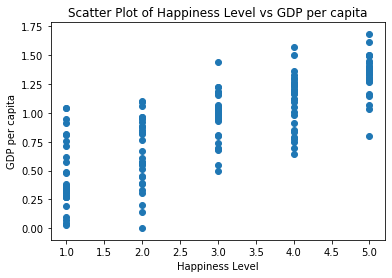

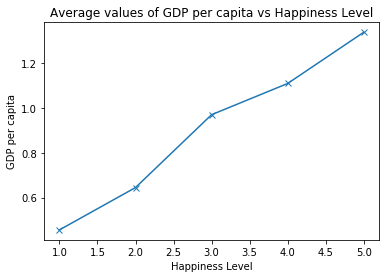

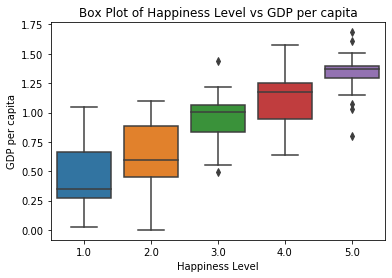

Happiness level vs Social support


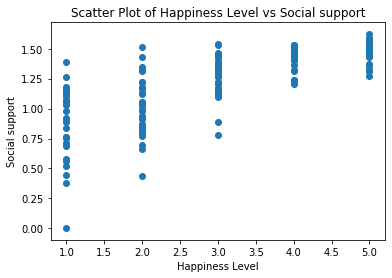

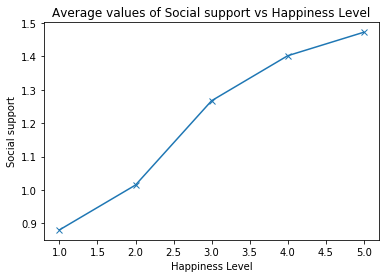

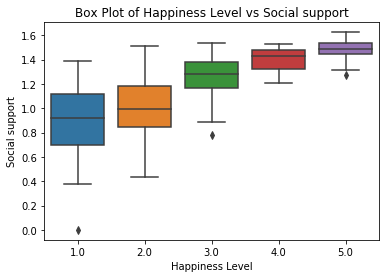

Happiness level vs Healthy life expectancy


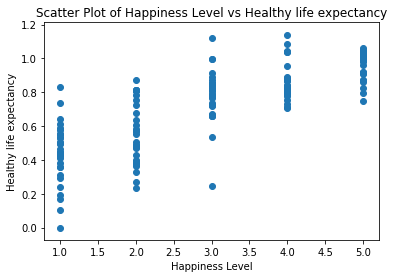

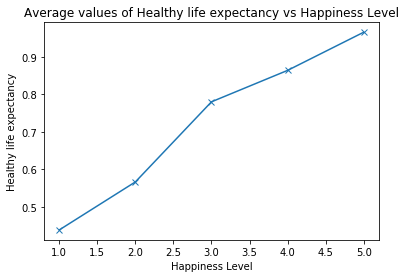

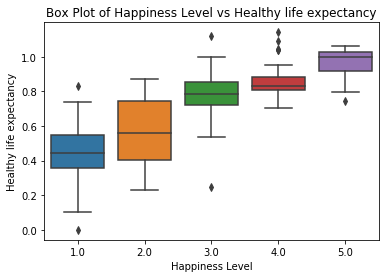

Happiness level vs Freedom to make life choices


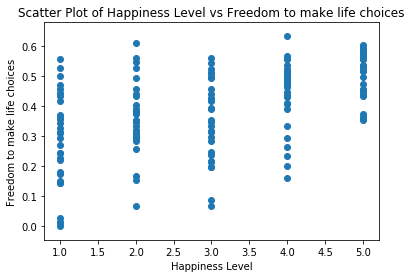

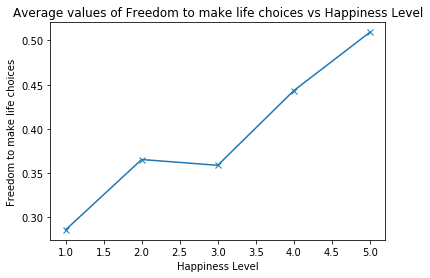

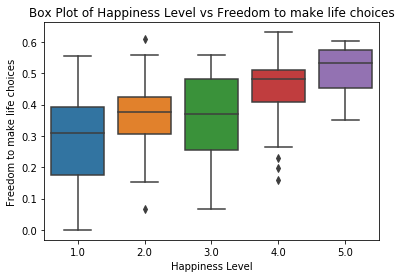

Happiness level vs Generosity


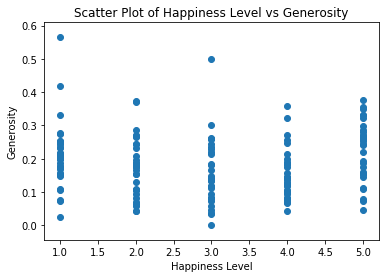

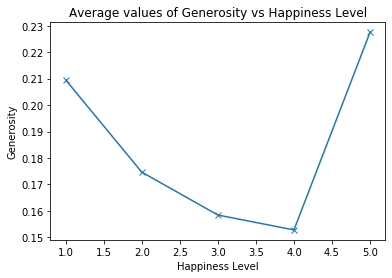

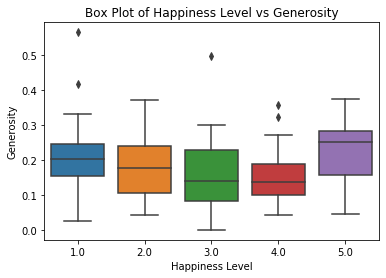

Happiness level vs Perceptions of corruption


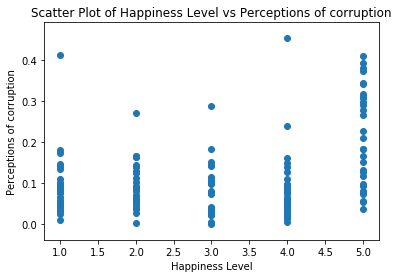

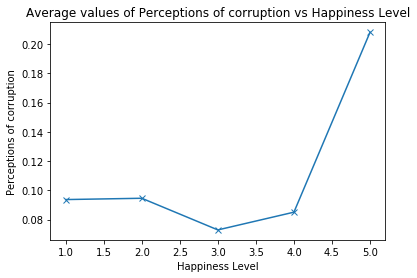

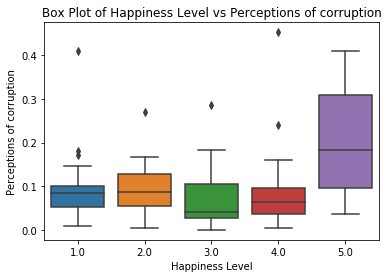

Happiness level vs region

Region Keys: {'Asia': 1, 'Europe': 2, 'Africa': 3, 'Oceania': 4, 'Americas': 5, nan: 6}


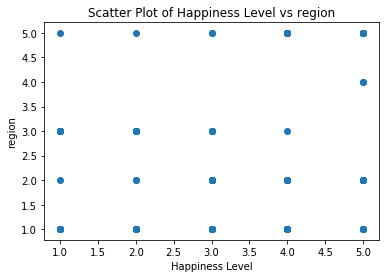


Region Keys: {'Asia': 1, 'Europe': 2, 'Africa': 3, 'Oceania': 4, 'Americas': 5, nan: 6}


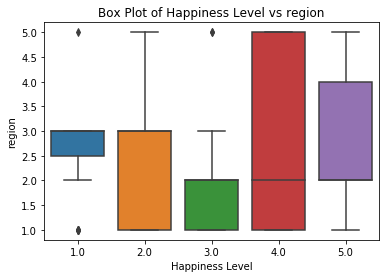

Happiness level vs CO2-per-capita


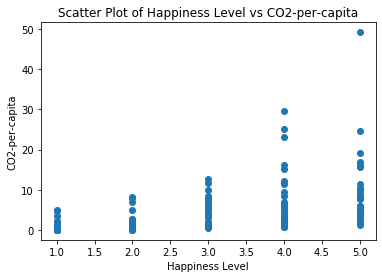

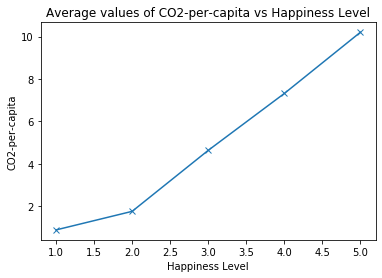

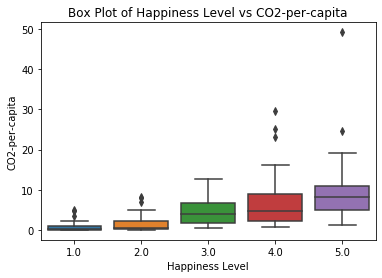

Happiness level vs fertility-rate


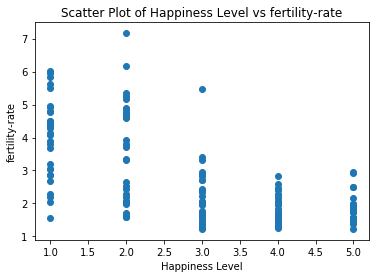

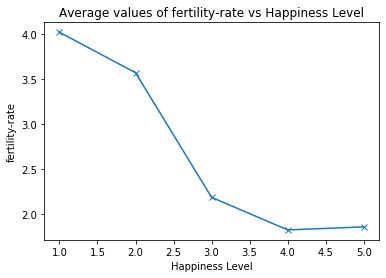

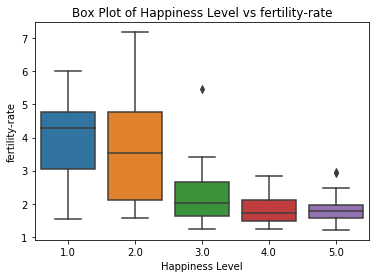

Happiness level vs infant-mortality-rate


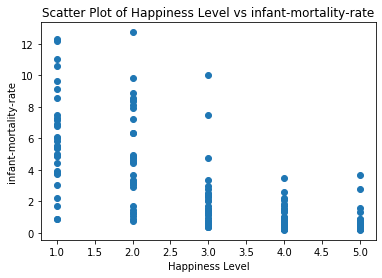

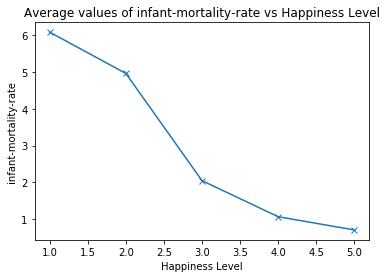

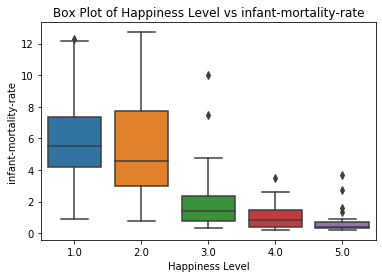

Happiness level vs pop-density


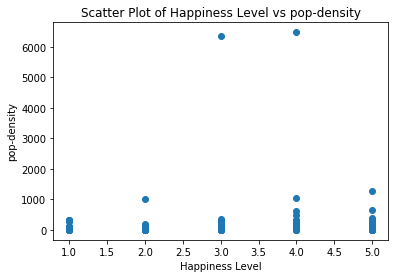

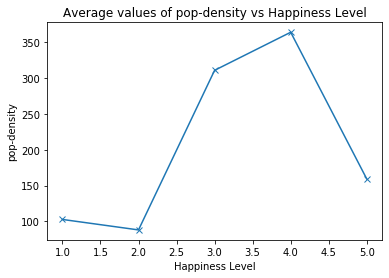

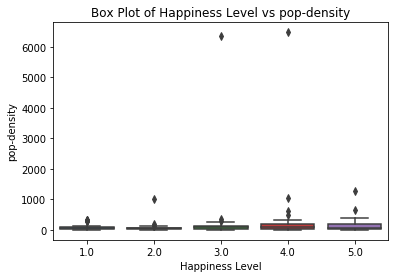

Happiness level vs net-migration


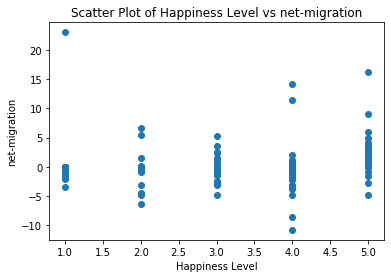

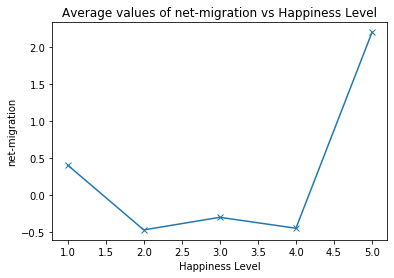

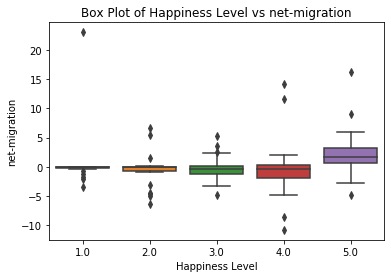

Happiness level vs literacy-rate


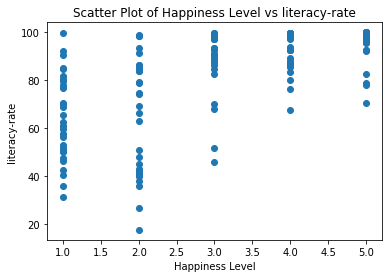

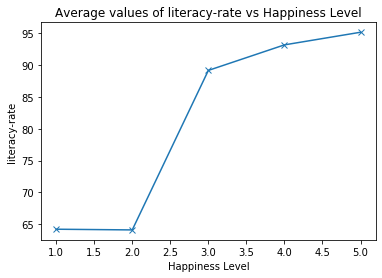

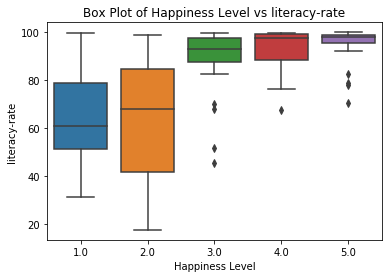

Happiness level vs death-rate


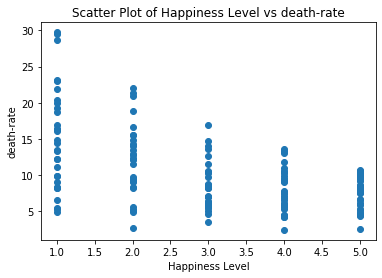

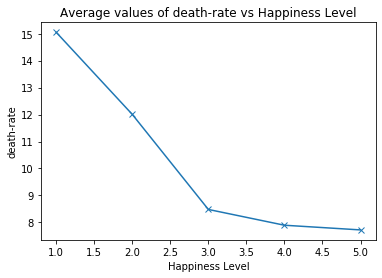

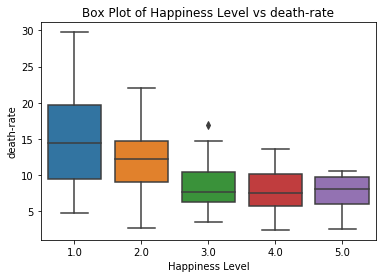

In [9]:
for x in columns:
    
    print("Happiness level vs", x)
    
    if x == "region":
        print("\nRegion Keys:", d)
    plt.scatter(control, indep_var[x])
    plt.title("Scatter Plot of Happiness Level vs " + str(x))
    plt.ylabel(x)
    plt.xlabel("Happiness Level")
    plt.show()
    
    if x != "region":
        grouped = hap_data.groupby('Happiness_level', as_index=False)[x].mean()
        plt.plot(grouped.ix[:,0], grouped.ix[:,-1], marker = "x")
        plt.title("Average values of " + str(x) +" vs Happiness Level")
        plt.ylabel(x)
        plt.xlabel("Happiness Level")
        plt.show()
    
    if x == "region":
        print("\nRegion Keys:", d)
    sns.boxplot(x = control, y = indep_var[x])
    plt.title("Box Plot of Happiness Level vs " + str(x))
    plt.xlabel("Happiness Level")
    plt.show()

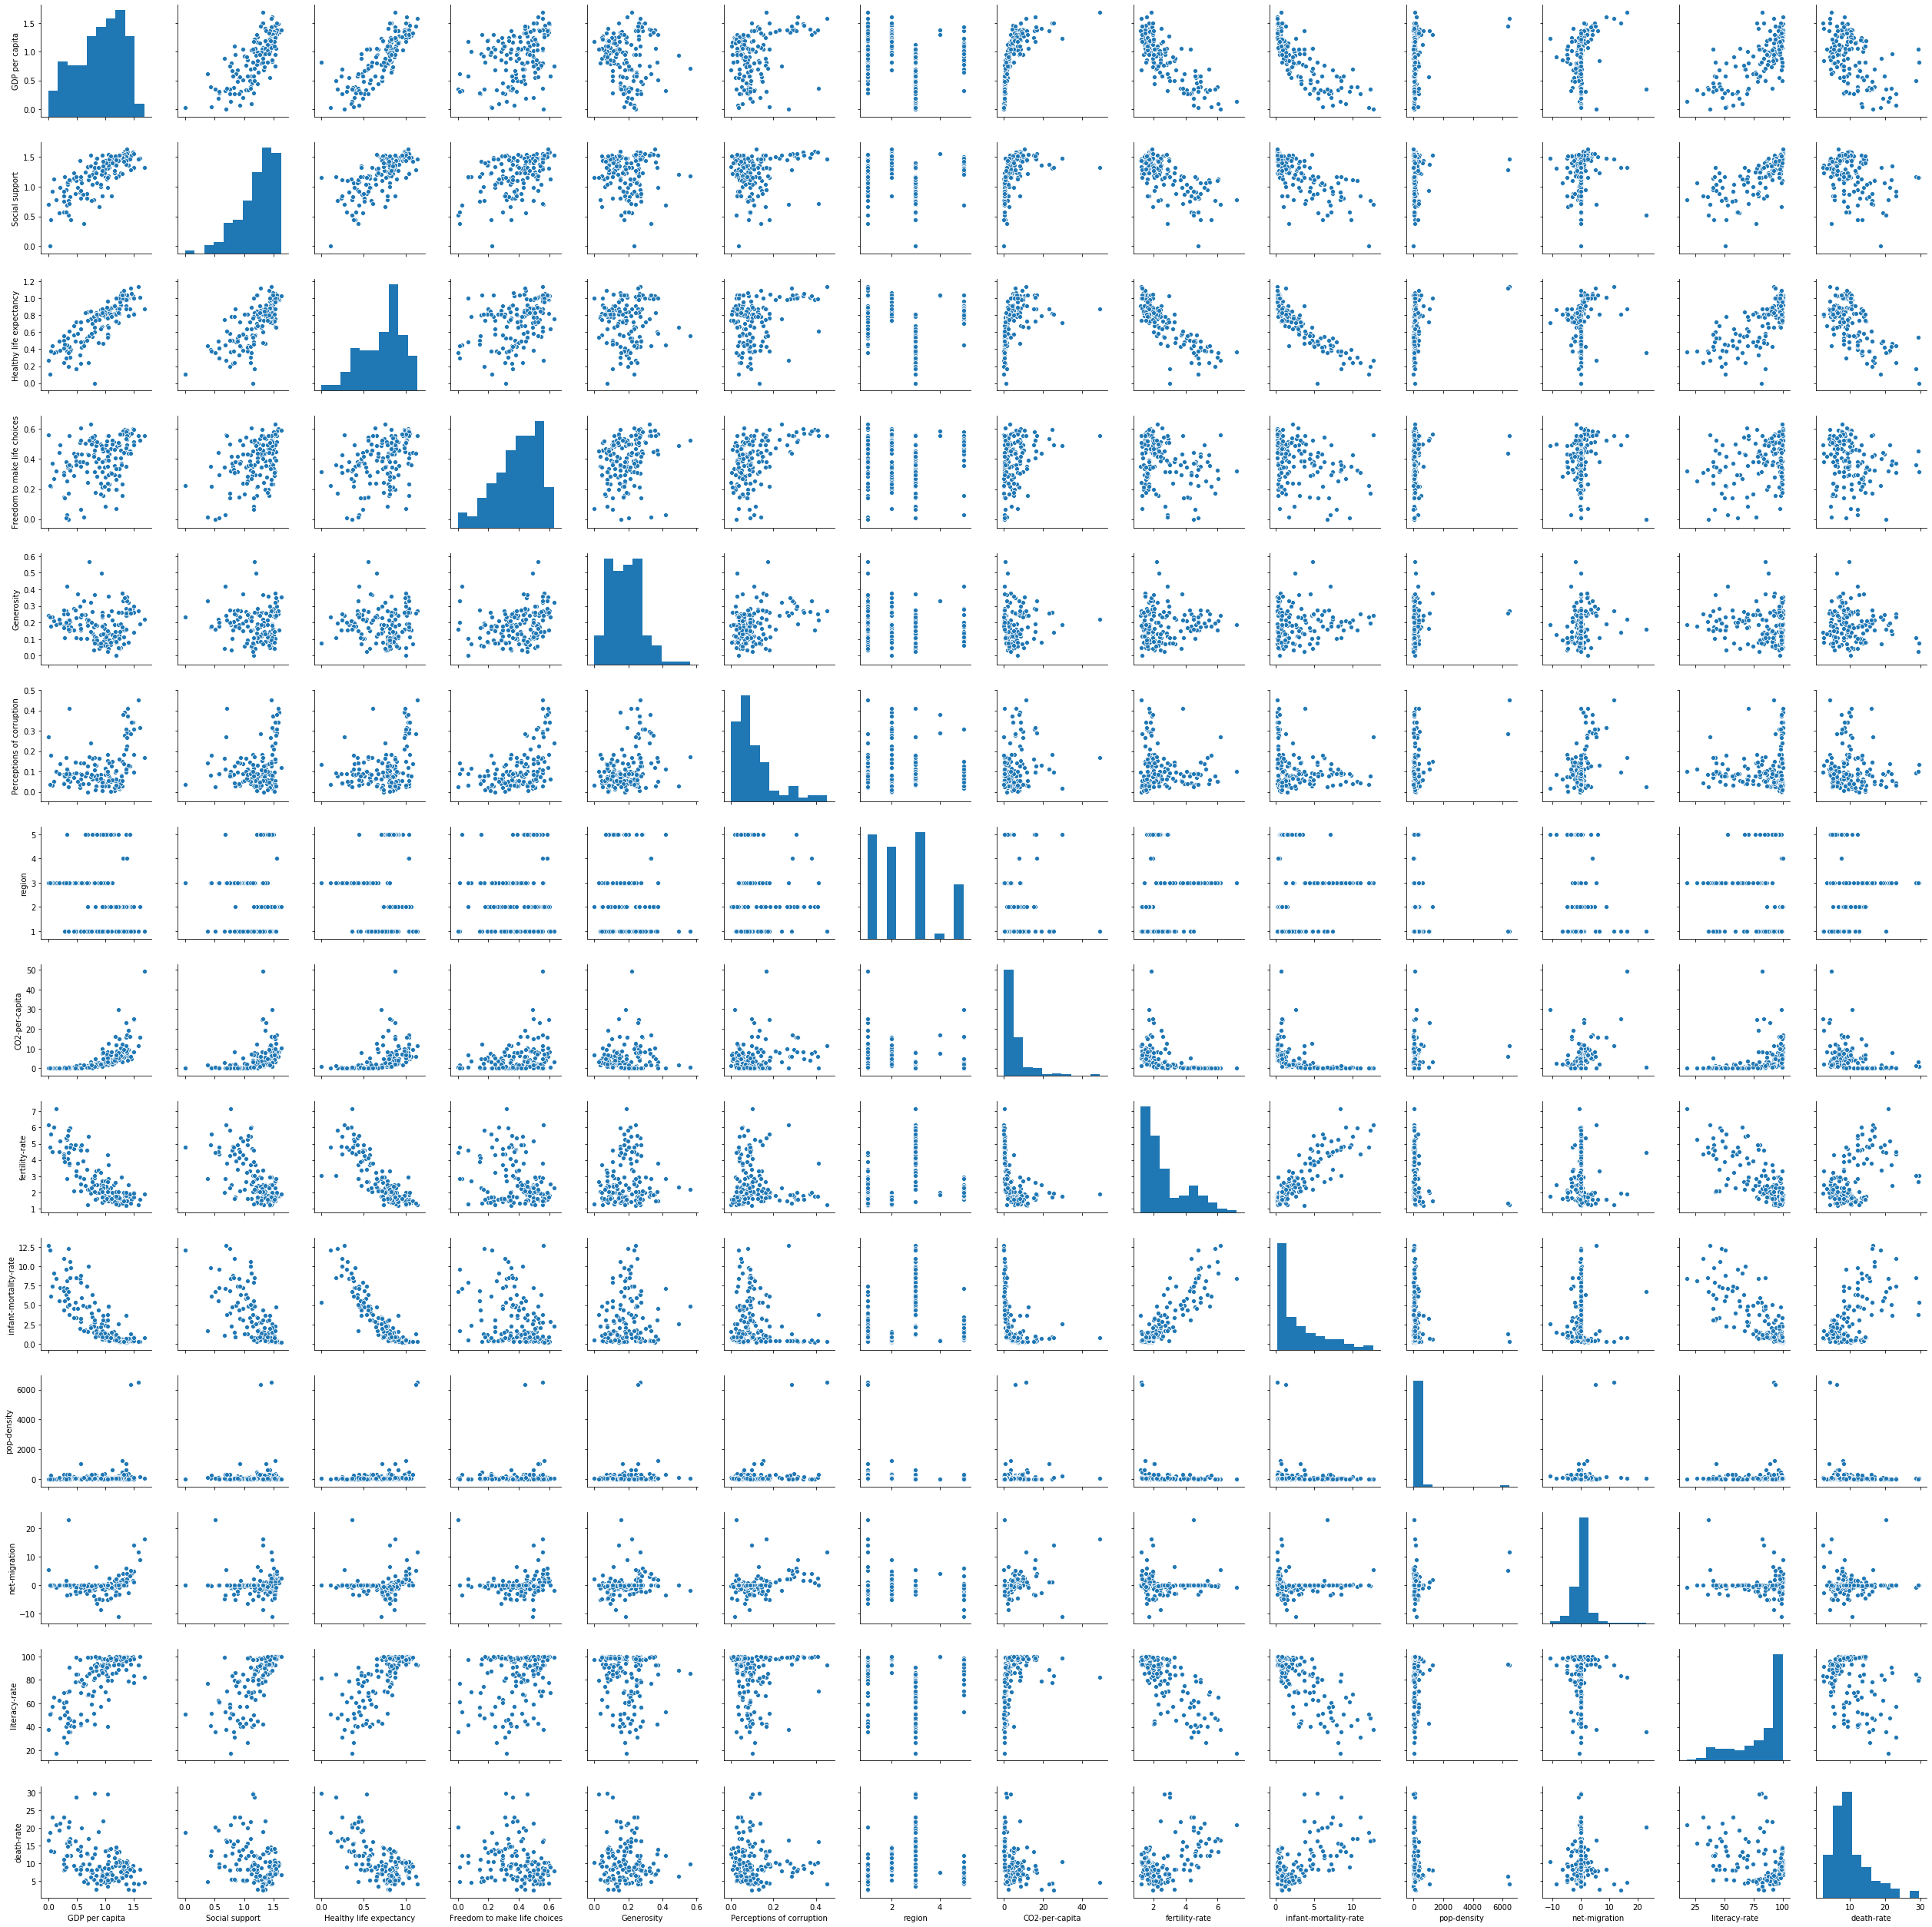

In [10]:
# look at pairplots

sns.pairplot(indep_var)

In [11]:
# look at correlation values, may be an indicator of important variables

hap_data.corr()

,Happiness_level,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,region,CO2-per-capita,fertility-rate,infant-mortality-rate,pop-density,net-migration,literacy-rate,death-rate
Happiness_level,1.000000,0.792683,0.741308,0.792472,0.521487,0.020681,0.329510,0.067793,0.527625,-0.640491,-0.676890,0.074538,0.140745,0.623577,-0.507057
GDP per capita,0.792683,1.000000,0.757650,0.835083,0.377359,-0.083889,0.296286,-0.194120,0.666356,-0.812453,-0.820777,0.201115,0.221848,0.739623,-0.471386
Social support,0.741308,0.757650,1.000000,0.722166,0.450566,-0.048109,0.183414,-0.009438,0.436291,-0.672477,-0.710645,0.074087,0.046304,0.707539,-0.325010
Healthy life expectancy,0.792472,0.835083,0.722166,1.000000,0.391319,-0.032315,0.294403,-0.124705,0.442869,-0.830393,-0.899063,0.238103,0.130883,0.726055,-0.633954
Freedom to make life choices,0.521487,0.377359,0.450566,0.391319,1.000000,0.262422,0.444639,0.030550,0.271204,-0.291385,-0.320097,0.115088,0.052800,0.323618,-0.191541
Generosity,0.020681,-0.083889,-0.048109,-0.032315,0.262422,1.000000,0.332859,-0.160284,0.028739,0.075549,0.117545,0.136792,0.149626,-0.082030,-0.068504
Perceptions of corruption,0.329510,0.296286,0.183414,0.294403,0.444639,0.332859,1.000000,-0.090308,0.196681,-0.113015,-0.168052,0.320004,0.330357,0.120120,-0.078424
region,0.067793,-0.194120,-0.009438,-0.124705,0.030550,-0.160284,-0.090308,1.000000,-0.204413,0.193936,0.172046,-0.176737,-0.221860,-0.093301,0.066129
CO2-per-capita,0.527625,0.666356,0.436291,0.442869,0.271204,0.028739,0.196681,-0.204413,1.000000,-0.435384,-0.450443,0.085098,0.329678,0.391759,-0.300571
fertility-rate,-0.640491,-0.812453,-0.672477,-0.830393,-0.291385,0.075549,-0.113015,0.193936,-0.435384,1.000000,0.877694,-0.169982,-0.019439,-0.770058,0.481320


In [12]:
# describe data to see if there are any null values
# shows that the count is 153 across all variables, so there are no null values

hap_data.describe()

,Happiness_level,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,region,CO2-per-capita,fertility-rate,infant-mortality-rate,pop-density,net-migration,literacy-rate,death-rate
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,3.006536,0.904582,1.208131,0.723307,0.392876,0.184837,0.111242,2.483660,4.980764,2.691699,2.963922,205.079085,0.285882,81.219542,10.230327
std,1.425781,0.400743,0.302087,0.243087,0.143830,0.095755,0.094926,1.328358,6.536070,1.346203,3.076757,740.067052,3.645776,20.736740,5.281980
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.048705,1.210000,0.210000,1.800000,-10.830000,17.600000,2.410000
25%,2.000000,0.578000,1.055000,0.538000,0.309000,0.109000,0.047000,1.000000,0.642214,1.710000,0.570000,28.200000,-0.740000,69.400000,6.250000
50%,3.000000,0.960000,1.277000,0.789000,0.417000,0.177000,0.086000,2.000000,2.728915,2.150000,1.520000,66.900000,0.000000,90.300000,9.160000
75%,4.000000,1.231000,1.454000,0.881000,0.508000,0.247000,0.141000,3.000000,6.926493,3.350000,4.730000,127.900000,0.680000,98.000000,12.640000
max,5.000000,1.684000,1.624000,1.141000,0.631000,0.566000,0.453000,5.000000,49.182623,7.180000,12.720000,6482.200000,23.060000,100.000000,29.740000


### Examine features that predict happiness categories using one or more models that allow for automatic feature selection

In [14]:
# use statsmodels OLS function to get p-values of variables, to determine which ones are relevant

y = hap_data["Happiness_level"]
X = hap_data.drop(["Happiness_level","Country or region"],axis=1)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

categorical_cols = X_train.dtypes == object

numeric_cols = ~categorical_cols

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('encoder', OneHotEncoder(handle_unknown='ignore'))])

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                   ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(transformers=[('categorical', categorical_transformer, categorical_cols),
                               ('numeric', numeric_transformer, numeric_cols)])

X_proc = preprocessor.fit_transform(X_train)

# Number of features after pre-processing

print("feat post pre-processing: ", X_proc.shape[1])


clf = LogisticRegression(penalty='l1', solver = "liblinear")

clf.fit(X_proc, y_train)

model = SelectFromModel(clf, prefit=True)

X_select_feats = model.transform(X_proc)

# Number of features after automatic feature selection

print("feat post automatic feature selection: ", X_select_feats.shape[1])

feat post pre-processing:  14
feat post automatic feature selection:  11


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Happiness_level   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     42.90
Date:                Mon, 17 Feb 2020   Prob (F-statistic):           3.22e-43
Time:                        07:51:31   Log-Likelihood:                -142.55
No. Observations:                 153   AIC:                             315.1
Df Residuals:                     138   BIC:                             360.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Run at least three prediction models to try to predict World Happiness well.

In [19]:
# Set up training and test data

y = hap_data["Happiness_level"]
X = hap_data.drop(["Happiness_level","Generosity","Perceptions of corruption",
                   "CO2-per-capita","fertility-rate","net-migration",
                   "literacy-rate","death-rate",'Country or region',"Social support"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_train.columns.tolist())

(114, 6)
(114,)
['GDP per capita', 'Healthy life expectancy', 'Freedom to make life choices', 'region', 'infant-mortality-rate', 'pop-density']


In [20]:
# Create preprocessing pipelines for both numeric and categorical data.

numeric_features = X.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = []

# Replace missing values with Modal value and then one hot encoding

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Final preprocessor object set up with ColumnTransformer

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit preprocessor object

prediction_input_preprocessor = preprocessor.fit(X_train) 

##### First Model : K Nearest Neighbors

In [21]:
m1 = "KNN"

model1 = KNeighborsClassifier()

model1.fit(prediction_input_preprocessor.transform(X_train), y_train)

y_pred = model1.predict(prediction_input_preprocessor.transform(X_test))

m1_f1_score = f1_score(y_test, y_pred,average="macro",zero_division=0)
m1_prec_score = precision_score(y_test, y_pred,average="macro",zero_division=0)

m1_accuracy = metrics.accuracy_score(y_test, y_pred)
m1_cv = np.mean(cross_val_score(model1, prediction_input_preprocessor.transform(X_train), y_train, cv=10))
m1_prediction_accuracy = model1.score(prediction_input_preprocessor.transform(X_test), y_test)

##### Second Model : Logistic Regression

In [22]:
m2 = "Logistic Regression"

model2 = LogisticRegression(C = 1000.0)

model2.fit(prediction_input_preprocessor.transform(X_train), y_train)

y_pred = model2.predict(prediction_input_preprocessor.transform(X_test))

m2_f1_score = f1_score(y_test, y_pred,average="macro",zero_division=0)
m2_prec_score = precision_score(y_test, y_pred,average="macro",zero_division=0)

m2_accuracy = metrics.accuracy_score(y_test, y_pred)
m2_cv = np.mean(cross_val_score(model2, prediction_input_preprocessor.transform(X_train), y_train, cv=10))
m2_prediction_accuracy = model2.score(prediction_input_preprocessor.transform(X_test), y_test)

##### Third Model : Random Forest Classifier

In [23]:
m3 = "Random Forest Classifier"

model3 = RandomForestClassifier(n_estimators=1000, random_state = 0)

model3.fit(prediction_input_preprocessor.transform(X_train), y_train)

y_pred = model3.predict(prediction_input_preprocessor.transform(X_test))

m3_f1_score = f1_score(y_test, y_pred,average="macro",zero_division=0)
m3_prec_score = precision_score(y_test, y_pred,average="macro",zero_division=0)

m3_accuracy = metrics.accuracy_score(y_test, y_pred)
m3_cv = np.mean(cross_val_score(model3, prediction_input_preprocessor.transform(X_train), y_train, cv=10))
m3_prediction_accuracy = model3.score(prediction_input_preprocessor.transform(X_test), y_test)

##### Fourth Model : Ridge Classifier

In [24]:
m4 = "Ridge Classifier"

model4 = RidgeClassifier()

model4.fit(prediction_input_preprocessor.transform(X_train), y_train)

y_pred = model4.predict(prediction_input_preprocessor.transform(X_test))

m4_f1_score = f1_score(y_test, y_pred,average="macro",zero_division=0)
m4_prec_score = precision_score(y_test, y_pred,average="macro",zero_division=0)

m4_accuracy = metrics.accuracy_score(y_test, y_pred)
m4_cv = np.mean(cross_val_score(model4, prediction_input_preprocessor.transform(X_train), y_train, cv=10))
m4_prediction_accuracy = model4.score(prediction_input_preprocessor.transform(X_test), y_test)

##### Results of all 4 models

In [25]:
print("Results for each model")

print("\n ", m1)
print(m1+"'s cross validation accuracy:", m1_cv)
print(m1+"'s Test-Data prediction accuracy:", m1_prediction_accuracy)
print(m1+"'s F1 score:", m1_f1_score)
print(m1+"'s precision score:", m1_prec_score)

print("\n ", m2)
print(m2+"'s cross validation accuracy:", m2_cv)
print(m2+"'s Test-Data prediction accuracy:", m2_prediction_accuracy)
print(m2+"'s F1 score:", m2_f1_score)
print(m2+"'s precision score:", m2_prec_score)

print("\n ", m3)
print(m3+"'s cross validation accuracy:", m3_cv)
print(m3+"'s Test-Data prediction accuracy:", m3_prediction_accuracy)
print(m3+"'s F1 score:", m3_f1_score)
print(m3+"'s precision score:", m3_prec_score)

print("\n ", m4)
print(m4+"'s cross validation accuracy:", m4_cv)
print(m4+"'s Test-Data prediction accuracy:", m4_prediction_accuracy)
print(m4+"'s F1 score:", m4_f1_score)
print(m4+"'s precision score:", m4_prec_score)


Results for each model

  KNN
KNN's cross validation accuracy: 0.5098484848484848
KNN's Test-Data prediction accuracy: 0.5128205128205128
KNN's F1 score: 0.4968253968253967
KNN's precision score: 0.538888888888889

  Logistic Regression
Logistic Regression's cross validation accuracy: 0.5401515151515153
Logistic Regression's Test-Data prediction accuracy: 0.6666666666666666
Logistic Regression's F1 score: 0.67597500538677
Logistic Regression's precision score: 0.7542857142857142

  Random Forest Classifier
Random Forest Classifier's cross validation accuracy: 0.5545454545454545
Random Forest Classifier's Test-Data prediction accuracy: 0.5641025641025641
Random Forest Classifier's F1 score: 0.5717896138948769
Random Forest Classifier's precision score: 0.6321445221445222

  Ridge Classifier
Ridge Classifier's cross validation accuracy: 0.49469696969696975
Ridge Classifier's Test-Data prediction accuracy: 0.46153846153846156
Ridge Classifier's F1 score: 0.40342794460441517
Ridge Classifi

In [26]:
# the best model was the Logistic Regression model
# this is model number 2, which is then saved as a pickle file

pickle.dump(model2, open( "rff_model.pkl", "wb" ) )

## Write up/Report on U.N. World Happiness

##### Explore bivariate results

There are many key observations that can be made on the relationships between the target variable, "Happiness Level", and many of the other variables both in the original dataset and then added to the dataset by myself.

By looking at the average GDP per capita for each country at each happiness level, there is a clear trend that as the average GDP per capita increases, the happiness level increases. Happiness Level 2 (low) has a statistically significantly lower GDP per capita than happiness level 3 (average), and the same can be said between happiness levels 4 and 5 (high and very high).

A similar trend as the aforementioned one is that between the social support one receives in the country and the happiness level of the country. There is also a clear trend that life expectancy increases as happiness level increases. 

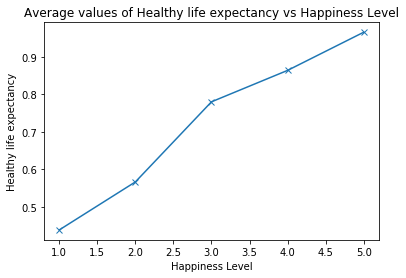

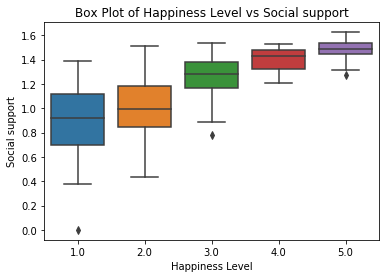

Interestingly, the levels of generosity decrease from “very low” happiness to “high” happiness, and that “high” happiness (a score of 4) has the lowest level of generosity. The highest level of generosity is “very high” happiness, followed by “very low” happiness.
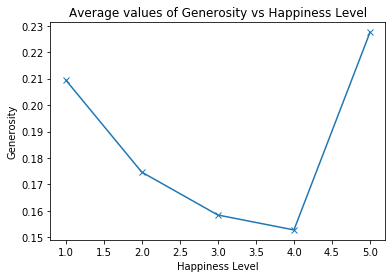

Perceptions of corruption tend to remain relatively low from happiness levels 1 to 4 (very low to high), however this then spikes at level 5, indicating “very high” happiness. 

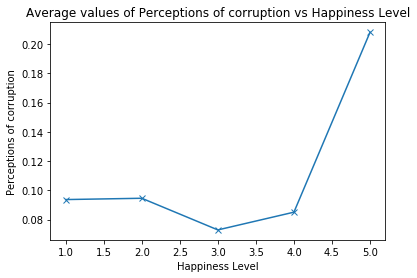

It is interesting to note that CO2 per capita increases as happiness level increases , though this makes sense as countries with a higher happiness tend to have a higher GDP per capita, and those countries tend to be MEDC countries (more economically developed countries); these countries produce and use more energy, have higher populations and thus have a higher CO2 per capita level. 

Unsurprisingly, the rates of infant mortality decrease as happiness levels increases. her is also a decrease in death-rate per capita as the happiness level increases, though this tends to plateau during levels 4 and 5. Further, countries that are the “most happy” also have the highest levels of positive net migration, whereas countries that rank 1-4 (very low to high) have negative rates of migration, meaning there is more emigration than immigration in countries which have a happiness level of 1-4.

There is also a spike in literacy rates in between countries that rank 1-2 and those that rank 3-5. There is a statistically significant difference between the countries that have a happiness level of 1-2 versus those that are 3-5, as shown by the box plot.

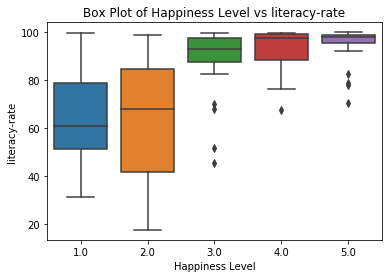

##### Examine features that predict happiness categories and explain any meaningful findings

Through automatic feature selection on a logistic regression model, only 1 of features were dropped - Generosity'. It suggested that the penalty "l1" should be used.

The OLS model showed that  "Generosity" , "Perceptions of corruption" , "CO2-per-capita" , "fertility-rate" , "net-migration" , "literacy-rate" and "death-rate" should be dropped, as their p-values are less than 0.05 meaning that they are stasticially insignificant relative to the results of the model.

##### Discuss which models performed better and point out relevant hyper-parameter values for successful models

The third part of the report asked for at least 3 different prediction models to try to predict World Happiness. I ended up using 4 models: a KNN, a Logisitic Regression, a Random Forrest Classifier and a Ridge Classifier.

The model which had the highest F1 score, highest precision score, and the best test-data prediction was the logisitc regression. The F1 score was 0.67598 (5dp), which was higher than the next highest F1 score by 0.10419 (this was in the Random Forest Classifier, which had an F1 score of 0.57179). The model precision score was 0.75429, which was higher than the next highest score by 0.12215 (this was also in the Random Forest Classifier, which had a score of 0.63214). The paramater C was varied between 1 and 1,000,000. Having C set at 1000.0 provided the logreg model with the greatest F1 and precision scores, thus it was used.

The Random Forest Classifier was the second best performing model. It achieved peak F1 and precision scores when the number of  estimators was set to 1000 and the random state was set to 0.

The model which performed the worst was the Ridge Classifier. It only had a precision score of 0.43870, an F1 scor of 0.40343 and a cross validation accuracy of 0.49470. The Ridge Classifier model perfored the worst relative to the other 3 models when judging by all metrics for scoring (eg accuracy on test data).

By running a simple OLS model on the data post the removal of variables which did not meet the threshold to be statiscally significant (the variables who's p-values were greater than 0.05), the R-squared and adjusted R-squared scores both decreased. The OLS results are displayed below. This indicates that the new model is not as accurate as the previous one. However, both the AIC and BIC scores decreased indicating that the new model is a "better" model than the previous one. This leads to the conclusion that one or more of the variables discarded could actually be part of a covariable, or that perhaps some of the variables should have been treated as polynomial variables.

In [27]:
X3 = sm.add_constant(X)
est = sm.OLS(y, X3)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        Happiness_level   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     94.01
Date:                Mon, 17 Feb 2020   Prob (F-statistic):           1.26e-47
Time:                        07:51:51   Log-Likelihood:                -149.86
No. Observations:                 153   AIC:                             313.7
Df Residuals:                     146   BIC:                             334.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           